In [7]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from typing import Callable, Dict, Tuple, Optional, Union
import autograd 
from autograd import grad, jacobian
import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append("/Users/MathijsDijkstra/University/Bachelors/Third year Econometrics/Robust-QLE-Model/")
from Volatility_model_progress.All_models import GAS_Model, Beta_t_GARCH11

class RobustQLEVolatilityModel:
    
    
    def __init__(self, alpha_loss: float = None, c: float = None):
        
        self.alpha_loss = alpha_loss
        self.c = c
        self.params = None
        self.param_names = ['omega', 'gamma', 'beta']
        if alpha_loss is None:
            self.param_names.append('alpha_loss')
        if c is None:
            self.param_names.append('c')
        self.fitted_volatility = None
        self.residuals = None
    
    def _rho_derivative(self, e: np.ndarray, alpha: float, c: float) -> np.ndarray:
        
        # Handle scalar inputs by converting to numpy arrays
        if np.isscalar(e):
            e = np.array([e])
            scalar_input = True
        else:
            scalar_input = False
            
        if alpha == 2:
            # L2 loss (least squares)
            result = e / (c**2)
        elif alpha == 0:
            # Cauchy/Lorentzian loss
            result = (2 * e) / (e**2 + 2 * c**2)
        elif alpha == float('-inf'):
            # Welsch/Leclerc loss
            result = (e / c**2) * np.exp(-0.5 * (e/c)**2)
        else:
            # General case
            result = (e / c**2) * np.power((e**2 / c**2) / np.abs(alpha-2) + 1, alpha/2 - 1)
        
        # Return scalar if input was scalar
        if scalar_input:
            return result[0]
        return result
    
    #def _rho_second_derivative(self, e: np.ndarray, alpha: float, c: float) -> np.ndarray:
        
        # Handle scalar inputs by converting to numpy arrays
        if np.isscalar(e):
            e = np.array([e])
            scalar_input = True
        else:
            scalar_input = False
            
        if alpha == 2:
            # L2 loss (least squares)
            result = np.ones_like(e) / (c**2)
        elif alpha == 0:
            # Cauchy/Lorentzian loss
            denom = (1 + 0.5 * (e/c)**2)**2
            result = (1 / c**2) * (1 - 0.5 * (e/c)**2) / denom
        elif alpha == float('-inf'):
            # Welsch/Leclerc loss
            result = (1 / c**2) * (1 - (e**2 / c**2)) * np.exp(-0.5 * (e/c)**2)
        else:
            # General case
            base_term = np.power((e/c)**2 / np.abs(alpha-2) + 1, alpha/2 - 2)
            part1 = (1 / c**2) * base_term
            part2 = (e/c)**2 / np.abs(alpha-2) + 1
            part3 = part2 + (alpha/2 - 1) * (2 * e**2) / (c**2 * np.abs(alpha-2))
            result = part1 * part3
            
        
        # Return scalar if input was scalar
        if scalar_input:
            return result[0]
        return result
    def _rho_second_derivative(self, e: np.ndarray, alpha: float, c: float) -> np.ndarray:
        
        # Handle scalar inputs by converting to numpy arrays
        if np.isscalar(e):
            e = np.array([e])
            scalar_input = True
        else:
            scalar_input = False
            
        if alpha == 2:
            # L2 loss (least squares)
            result = -np.ones_like(e) / (c**2)
        elif alpha == 0:
            # Cauchy/Lorentzian loss
            denom = (e**2 + 2 * c**2)**2
            result = -(2*(e**2 + 2* c**2) - 4 * e **2) / denom
        elif alpha == float('-inf'):
            # Welsch/Leclerc loss
            first_term = ((e)**2 * np.exp( -((e**2)/(2* (c**2)))))/(c**4)
            second_term = np.exp( -((e**2)/(2* (c**2))))/(c**2)
            result = (first_term - second_term)
        else:
            # General case
            e2 = (e)**2
            denom = c**2 * np.abs(alpha - 2)
            A = e2 / denom + 1

            term1 = -2 * (alpha/2 - 1) * A**(alpha/2 - 2) * e2
            term1 /= (c**4 * np.abs(alpha - 2))

            term2 = - A**(alpha/2 - 1) / (c**2)

            return term1 + term2
            
        
        # Return scalar if input was scalar
        if scalar_input:
            return result[0]
        return result
    
    #def dpsi_dalpha(self, e_t, c, alpha_loss):
        
        # define a small neighborhood around the problematic points:
        eps = 1e-4

        # if α is within ±eps of 2, treat it as exactly 2 (L2 case)
        if abs(alpha_loss - 2) < eps:
            delta = 1e-5
            psi_plus = self._rho_derivative(e_t, alpha_loss + delta, self.c) 
            psi_minus = self._rho_derivative(e_t, alpha_loss - delta, self.c) 
            dpsi_dalpha = (psi_plus - psi_minus) / (2 * delta)
            return dpsi_dalpha  # ∂ψ/∂α = 0 for the L2 loss

        # similarly guard α≈0
        if abs(alpha_loss - 0) < eps:
            # use the closed-form ∂ψ/∂α at α=0 (which you've already set to 0)
            delta = 1e-5
            psi_plus = self._rho_derivative(e_t, alpha_loss + delta, self.c) 
            psi_minus = self._rho_derivative(e_t, alpha_loss - delta, self.c)
            dpsi_dalpha = (psi_plus - psi_minus) / (2 * delta)
            return dpsi_dalpha

        # if you ever parameterize "α = −∞" as, say, alpha_loss < some negative cutoff
        if alpha_loss < -1e3:
            delta = 1e-5
            psi_plus = self._rho_derivative(e_t, alpha_loss + delta, self.c) 
            psi_minus = self._rho_derivative(e_t, alpha_loss - delta, self.c) 
            dpsi_dalpha = (psi_plus - psi_minus) / (2 * delta)
            return dpsi_dalpha  

        # otherwise you're safely away from the singularities, so use your general formula:
        abs_alpha_minus_2 = np.abs(alpha_loss - 2)
        denominator_inner = c**2 * abs_alpha_minus_2
        inner_term = (e_t**2) / denominator_inner + 1
        power_term = inner_term**(alpha_loss / 2 - 1)

        log_term = np.log(inner_term) / 2
        frac_term = (e_t**2 * (alpha_loss / 2 - 1)) / (
            c**2 * inner_term * abs_alpha_minus_2 * (alpha_loss - 2)
        )

        numerator = e_t * power_term * (log_term - frac_term)

        return (numerator / c**2)
    def dpsi_dalpha(self, e_t, c, alpha_loss):
        
        # define a small neighborhood around the problematic points:
        eps = 1e-4

        # if α is within ±eps of 2, treat it as exactly 2 (L2 case)
        if abs(alpha_loss - 2) < eps:
            delta = 1e-5
            psi_plus = self._rho_derivative(e_t, alpha_loss + delta, self.c) 
            psi_minus = self._rho_derivative(e_t, alpha_loss - delta, self.c) 
            dpsi_dalpha = (psi_plus - psi_minus) / (2 * delta)
            return dpsi_dalpha  # ∂ψ/∂α = 0 for the L2 loss

        # similarly guard α≈0
        if abs(alpha_loss - 0) < eps:
            # use the closed-form ∂ψ/∂α at α=0 (which you've already set to 0)
            delta = 1e-5
            psi_plus = self._rho_derivative(e_t, alpha_loss + delta, self.c) 
            psi_minus = self._rho_derivative(e_t, alpha_loss - delta, self.c) 
            dpsi_dalpha = (psi_plus - psi_minus) / (2 * delta)
            return dpsi_dalpha

        # if you ever parameterize "α = −∞" as, say, alpha_loss < some negative cutoff
        if alpha_loss < -1e3:
            delta = 1e-5
            psi_plus = self._rho_derivative(e_t, alpha_loss + delta, self.c) 
            psi_minus = self._rho_derivative(e_t, alpha_loss - delta, self.c)
            dpsi_dalpha = (psi_plus - psi_minus) / (2 * delta)
            return dpsi_dalpha  

        # otherwise you're safely away from the singularities, so use your general formula:
        alpha= alpha_loss
        e2 = e_t**2
        denom = c**2 * np.abs(alpha - 2)
        A = (e2 / denom) + 1

        # Compute the bracket term
        term_log = np.log(A) / 2
        term_frac = (e2 * (alpha/2 - 1)) / (c**2 * A * np.abs(alpha - 2) * (alpha - 2))
        bracket = term_log - term_frac

        # Combine everything
        result = (e_t * A**(alpha/2 - 1) * bracket) / (c**2)
        return result

    
    #def dpsi_dc(self, e_t, c, alpha_loss):
       
        eps = 1e-4

        if alpha_loss == 2:
            # dψ/dc = -2e / c³
            return -2 * e_t / c**3

        elif abs(alpha_loss) < eps:
            # dψ/dc = -8ec / (e² + 2c²)²
            return -8 * e_t * c / (e_t**2 + 2 * c**2)**2

        elif alpha_loss < -1e3:
            # dψ/dc = ( -2e / c³ + e³ / c⁵ ) * exp(-½ (e/c)²)
            z = e_t / c
            exp_term = np.exp(-0.5 * z**2)
            return (-2 * e_t / c**3 + e_t**3 / c**5) * exp_term

        else:
            # General case:
            # dψ/dc = [ -2e / c³ 
            #           + (e / c²)(α/2 - 1)( (e² / (c²|α−2|) + 1 )**(α/2 - 2) ) * (-2e² / (c³|α−2|)) ]
            #         * (e² / (c²|α−2|) + 1 )**(α/2 - 1)
            abs_alpha_diff = np.abs(alpha_loss - 2)
            z_sq = (e_t**2) / (c**2 * abs_alpha_diff)
            base = z_sq + 1
            power1 = (alpha_loss / 2) - 2
            power2 = (alpha_loss / 2) - 1

            first_term = -2 * e_t / c**3
            second_term = (e_t / c**2) * ((alpha_loss / 2) - 1) * (base**power1) * (-2 * e_t**2 / (c**3 * abs_alpha_diff))

            return (first_term + second_term) * base**power2
    def dpsi_dc(self, e_t, c, alpha_loss):
       
        eps = 1e-4

        if alpha_loss == 2:
            # dψ/dc = -2e / c³
            return -2 * e_t / c**3

        elif abs(alpha_loss) < eps:
            # dψ/dc = -8ec / (e² + 2c²)²
            return -8 * e_t * c / (e_t**2 + 2 * c**2)**2

        elif alpha_loss < -1e3:
            # dψ/dc = ( -2e / c³ + e³ / c⁵ ) * exp(-½ (e/c)²)
            z = e_t / c
            exp_term = np.exp(-0.5 * z**2)
            return (-2 * e_t / c**3 + e_t**3 / c**5) * exp_term

        else:
            alpha = alpha_loss
            e2 = e_t**2
            denom = np.abs(alpha - 2) * c**2
            A = e2 / denom + 1

            term1 = -2 * e_t * A**(alpha/2 - 1) / (c**3)
            term2 = -2 * e_t**3 * (alpha/2 - 1) * A**(alpha/2 - 2) / (np.abs(alpha - 2) * c**5)
            
            return term1 + term2
            # General case:
            
    
    def _filter_volatility(self, y: np.ndarray, params: np.ndarray) -> np.ndarray:
        
        T = len(y)
        omega, gamma, beta = params[:3]
        
        param_idx = 3
        
        # Get alpha_loss parameter
        if self.alpha_loss is None:
            alpha_loss = params[param_idx]
            param_idx += 1
        else:
            alpha_loss = self.alpha_loss
        
        # Get c parameter
        if self.c is None:
            c = params[param_idx]
        else:
            c = self.c
        
        # Initialize volatility with the unconditional variance
        f = np.zeros(T+1)
        f[0] = omega/(1-beta)
        
        # Recursively update the volatility
        for t in range(T):
            e_t = y[t]**2 - f[t]
            psi_t = self._rho_derivative(e_t, alpha_loss, c)   
            f[t+1] = omega + gamma * psi_t + beta * f[t]
            
            # Enforce positive volatility
            f[t+1] = max(f[t+1], 1e-12)
        
        return f[1:]
    
    def _compute_derivatives(self, y: np.ndarray, f: np.ndarray, params: np.ndarray) -> np.ndarray:
       
        T = len(y)
        omega, gamma, beta = params[:3]
        
        param_idx = 3
        n_params = 3
        
        # Get alpha_loss parameter
        if self.alpha_loss is None:
            alpha_loss = params[param_idx]
            param_idx += 1
            n_params += 1
        else:
            alpha_loss = self.alpha_loss
        
        # Get c parameter
        if self.c is None:
            c = params[param_idx]
            n_params += 1
        else:
            c = self.c
        
        # Initialize derivatives of f_t with respect to theta
        e0 = y[0]**2 - f[0]
        psi0 =  self._rho_derivative(e0, alpha_loss, c)
        d2psi0_df = self._rho_second_derivative(e0, alpha_loss, c) 
        df_dtheta = np.zeros((T, n_params))
        df_dtheta[0, 0] = 1                  # ∂f₁/∂ω
        df_dtheta[0, 1] = psi0               # ∂f₁/∂γ
        df_dtheta[0, 2] = f[0]               # ∂f₁/∂β
        
        # Initialize derivatives for alpha_loss and c if they are estimated
        param_idx = 3
        
        if self.alpha_loss is None:
            dpsi0_dalpha = self.dpsi_dalpha(e0, c, alpha_loss)
            df_dtheta[0, param_idx] = gamma * dpsi0_dalpha  # ∂f₁/∂α
            param_idx += 1
        
        if self.c is None:
            dpsi0_dc = self.dpsi_dc(e0, c, alpha_loss)
            df_dtheta[0, param_idx] = gamma * dpsi0_dc  # ∂f₁/∂c
    
        # According to the recursive formula:
        
        for t in range(1, T):
            e_t = (y[t-1]**2 - f[t-1])
            psi_t = self._rho_derivative(e_t, alpha_loss, c)  
            d2psi_df = self._rho_second_derivative(e_t, alpha_loss, c)   
            
            # Common term in recursive updates
            common_term = gamma * d2psi_df + beta
            
            # Derivative with respect to parameters
            # For omega (∂ω/∂θ_0 = 1, else 0)
            df_dtheta[t, 0] = 1 + df_dtheta[t-1, 0] * common_term
            
            # For gamma (∂γ/∂θ_1 = 1, else 0)
            df_dtheta[t, 1] = psi_t + df_dtheta[t-1, 1] * common_term
            
            # For beta (∂β/∂θ_2 = 1, else 0)
            df_dtheta[t, 2] = f[t-1] + df_dtheta[t-1, 2] * common_term
            
            # Reset param_idx for additional parameters
            param_idx = 3
            
            # Derivative with respect to alpha_loss, if applicable
            if self.alpha_loss is None:
                dpsi_dalpha = self.dpsi_dalpha(e_t, c, alpha_loss)
                df_dtheta[t, param_idx] = gamma * dpsi_dalpha + common_term * df_dtheta[t-1, param_idx]
                param_idx += 1
            
            # Derivative with respect to c, if applicable
            if self.c is None:
                dpsi_dc = self.dpsi_dc(e_t, c, alpha_loss)
                df_dtheta[t, param_idx] = gamma * dpsi_dc + common_term * df_dtheta[t-1, param_idx]
        
        return df_dtheta
    
    def _qle_objective(self, params: np.ndarray, y: np.ndarray) -> float:
        
        try:
            # Apply parameter constraints
            param_idx = 3
            
            if self.alpha_loss is None:
                # Ensure alpha_loss is in reasonable range
                if params[param_idx] < -10 or params[param_idx] > 10:
                    return 1e10
                param_idx += 1
            
            if self.c is None:
                # Ensure c is positive and reasonable
                if params[param_idx] <= 0 or params[param_idx] > 10:
                    return 1e10
            
            # Basic parameter constraints for volatility model stability
            if params[0] <= 0 or params[1] < 0 or params[2] < 0 or params[2] >= 1 or params[1] + params[2] >= 0.999:
                return 1e10
            
            # Filter volatility
            f = self._filter_volatility(y, params)
            
            # Compute residuals - h_t is defined as y_t^k - f_t(θ)
            h_t = y**2 - f
            
            # Use f as the conditional variance approximation
            sigma2_t = f
            
            # Compute derivatives of f_t with respect to parameters
            df_dtheta = self._compute_derivatives(y, f, params)
            
            # G_t(θ) = (1/T) * sum[ h_t(θ) / σ²_t(θ) * ∂f_t(θ)/∂θ ]
            G_t = np.sum(h_t.reshape(-1, 1) / sigma2_t.reshape(-1, 1) * df_dtheta, axis=0) / len(y)
            
            # The objective is to minimize ||G_t(θ)||²
            obj = np.linalg.norm(G_t)
            
            return obj
        except Exception as e:
            print(f"Error in objective function: {e}")
            return 1e10
    
    def fit(self, y: np.ndarray, initial_params: Optional[Dict] = None, 
            method: str = 'Nelder-Mead', maxiter: int = 2000) -> Dict:
        
        # Set default initial parameters if not provided
        if initial_params is None:
            initial_params = {
                'omega': 0.07, 
                'gamma': 0.11, 
                'beta': 0.8
            }
            if self.alpha_loss is None:
                initial_params['alpha_loss'] = 1.5  # Default value close to Cauchy loss
            
            if self.c is None:
                initial_params['c'] = 0.9 # Default value for scale parameter
        
        # Prepare initial parameter array
        init_params = np.array([initial_params[name] for name in self.param_names])
        
        # Run optimization
        options = {'maxiter': maxiter, 'disp': True}
        
        # Different optimization methods may work better in different cases
        if method == 'Nelder-Mead':
            options['adaptive'] = True  # Use adaptive Nelder-Mead for better convergence
            result = minimize(
                self._qle_objective, 
                init_params, 
                args=(y,), 
                method=method, 
                options=options,
            )
        elif method == 'BFGS':
            options = {'maxiter': maxiter, 'gtol': 1e-6}
            result = minimize(
                self._qle_objective, 
                init_params, 
                args=(y,), 
                method=method, 
                options=options,
            )
        elif method == 'differential_evolution':
            # Set up bounds for differential evolution
            bounds = []
            
            # Basic parameters bounds
            bounds.extend([(0.001, 0.5), (0.001, 0.5), (0.6, 0.999)])
            
            # Alpha bounds if estimated
            if self.alpha_loss is None:
                bounds.append((-5, 5))
            
            # c bounds if estimated
            if self.c is None:
                bounds.append((0.1, 5.0))
            
            result = differential_evolution(
                self._qle_objective,
                bounds=bounds,
                args=(y,),
                strategy='best1bin',
                maxiter=maxiter,
                disp=True,
                polish=True
            )
        
        if not result.success and method != 'differential_evolution':
            print(f"Warning: Optimization did not converge: {result.message}")
            
            # Try again with different method if first one failed
            if method == 'Nelder-Mead':
                print("Trying BFGS method instead...")
                result = minimize(
                    self._qle_objective,
                    init_params,
                    args=(y,),
                    method='BFGS',
                    options={'maxiter': maxiter}
                )
        
        # Store parameters
        self.params = {name: val for name, val in zip(self.param_names, result.x)}
        
        # Compute fitted volatility
        param_array = np.array([self.params[name] for name in self.param_names])
        self.fitted_volatility = self._filter_volatility(y, param_array)
        self.residuals = y**2 - self.fitted_volatility
        
        print(f"Optimization result: {result.message}")
        print(f"Parameters: {self.params}")
        
        return self.params
    
    
    
    def plot_volatility(self, y: np.ndarray, true_vol: np.ndarray = None, title: str = "Estimated Volatility") -> None:
        
        if self.fitted_volatility is None:
            raise ValueError("Model must be fit before plotting")
        
        plt.figure(figsize=(12, 8))
        
        # Plot original data
        plt.subplot(2, 1, 1)
        plt.plot(y, 'b-', alpha=0.5, label='Returns')
        plt.title(title)
        plt.legend()
        
        # Plot volatility
        plt.subplot(2, 1, 2)
        plt.plot(np.sqrt(self.fitted_volatility), 'r-', label='Estimated Volatility')
        
        if true_vol is not None:
            plt.plot(np.sqrt(true_vol), 'b-', alpha=0.3, label='True Volatility')
        
        plt.legend()
        plt.ylim(0, np.max(np.sqrt(self.fitted_volatility)) * 1.5)
        plt.tight_layout()
        plt.show()
    
    def simulate(self, T: int, dist: str = 't', df: int = 5, seed: int = None, initial_vol = None) -> Tuple[np.ndarray, np.ndarray]:
        
        if self.params is None:
            raise ValueError("Parameters must be set before simulation")
        
        if seed is not None:
            np.random.seed(seed)
        
        omega = self.params['omega']
        gamma = self.params['gamma']
        beta = self.params['beta']
        
        if self.alpha_loss is None:
            alpha_loss = self.params['alpha_loss']
        else:
            alpha_loss = self.alpha_loss
        
        if self.c is None:
            c = self.params['c']
        else:
            c = self.c
        
        # Initialize arrays
        y = np.zeros(T)
        f = np.zeros(T+1)
        if initial_vol is not None:
            f[0] = initial_vol
        else:
            f[0] = omega / (1 - beta)  # Start at unconditional variance
        
        # Generate innovations
        if dist == 't':
            eps = np.random.standard_t(df, T)
        else:
            eps = np.random.normal(0, 1, T)
            
        # Generate data
        for t in range(T):
            # Generate return
            y[t] = np.sqrt(f[t]) * eps[t]
            
            # Compute the score
            e_t = (y[t]**2 - f[t])
            psi_t = self._rho_derivative(e_t, alpha_loss, c) 
            
            # Update volatility
            f[t+1] = omega + gamma * psi_t + beta * f[t]
            #f[t+1] = max(f[t+1], 1e-12)  # Ensure positive volatility
            
        return y, f[1:]

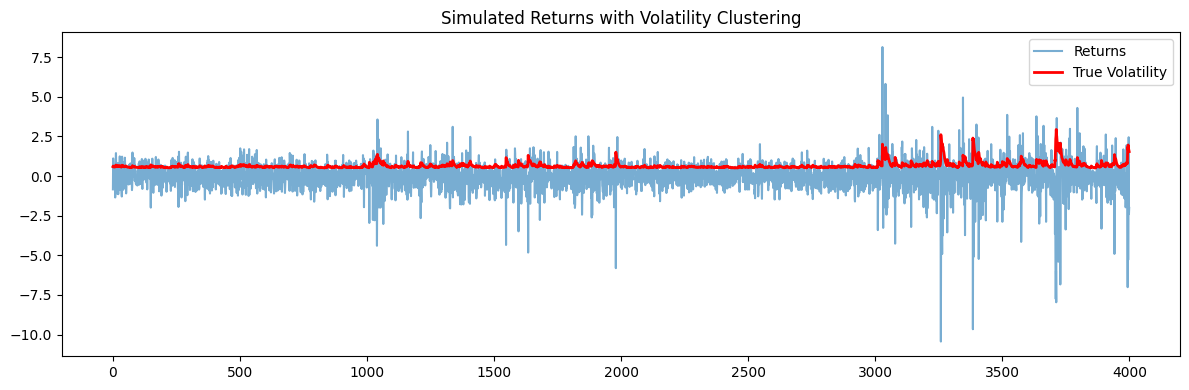

KeyboardInterrupt: 

In [6]:
def simulate_qle_volatility_clusters(
    model_class,
    cluster_params: list,
    cluster_lengths: list,
    dist: str = 'normal',
    df: int = 5,
    seed: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulate return series with QLE dynamics and regime-based parameter changes.

    Args:
        model_class: A QLE volatility model class (e.g. RobustQLEVolatilityModel)
        cluster_params: List of dicts, each containing model parameters for one regime
        cluster_lengths: List of lengths of each cluster (must sum to total T)
        dist: 'normal' or 't'
        df: degrees of freedom if t-distributed
        seed: random seed
    Returns:
        y: full return series
        vol: true conditional variances
        regimes: regime indicator (same length as y)
    """
    true_params_regime = {
        'omega': 0.05,
        'gamma': 0.08,
        'beta': 0.85,
        'alpha_loss': 2,
        'c': 1.2
    }
    
    QLE = RobustQLEVolatilityModel(alpha_loss=true_params_regime['alpha_loss'], c=true_params_regime['c'])
    QLE.params = true_params_regime
   
    
    #create data that has normal and t-distributed returns accoring to Robust class
    y = np.ones(4000)
    y[0:1000], vol1 = QLE.simulate(1000, dist='normal')
    y[1000:2000], vol2 = QLE.simulate(1000, dist='t', df=5)
    y[2000:3000], vol3 = QLE.simulate(1000, dist='normal')
    y[3000:4000], vol4 = QLE.simulate(1000, dist='t', df=3)
    vol = np.concatenate([vol1, vol2, vol3, vol4])
    regimes = np.ones(4000)
    return y, vol, regimes

y, vol, regimes = simulate_qle_volatility_clusters(RobustQLEVolatilityModel, [0.05, 0.08, 0.02], [3000, 3000, 4000], dist='normal', df=5, seed=123)
#plot the data
plt.figure(figsize=(12, 4))
plt.plot(y, label="Returns", alpha=0.6)
plt.plot(np.sqrt(vol), color='red', label="True Volatility", linewidth=2)
plt.legend()
plt.title("Simulated Returns with Volatility Clustering")
plt.tight_layout()
plt.show()
#fit model to data

QLE = RobustQLEVolatilityModel()
QLE.fit(y)

#plot the results
plt.figure(figsize=(12, 4))
plt.plot(QLE.fitted_volatility, label="Fitted Volatility", linewidth=2)
plt.plot(vol, color='red', label="True Volatility", linewidth=2)
plt.legend()
plt.title("Fitted Volatility vs True Volatility")
plt.tight_layout()
plt.show()






In [43]:
gas_model = GAS_Model(y)
gas_model.fit()

# Create and fit Beta-t-GARCH model for comparison
beta_t_model = Beta_t_GARCH11(y)
beta_t_model.fit()


Optimization terminated successfully.
         Current function value: 4734.873111
         Iterations: 81
         Function evaluations: 141


  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 4603.298488144036
        x: [ 2.120e-02  1.275e-01  8.445e-01  5.909e+00]
      nit: 23
      jac: [-3.292e-02  3.893e-02  2.219e-02 -1.637e-03]
     nfev: 150
     njev: 30
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

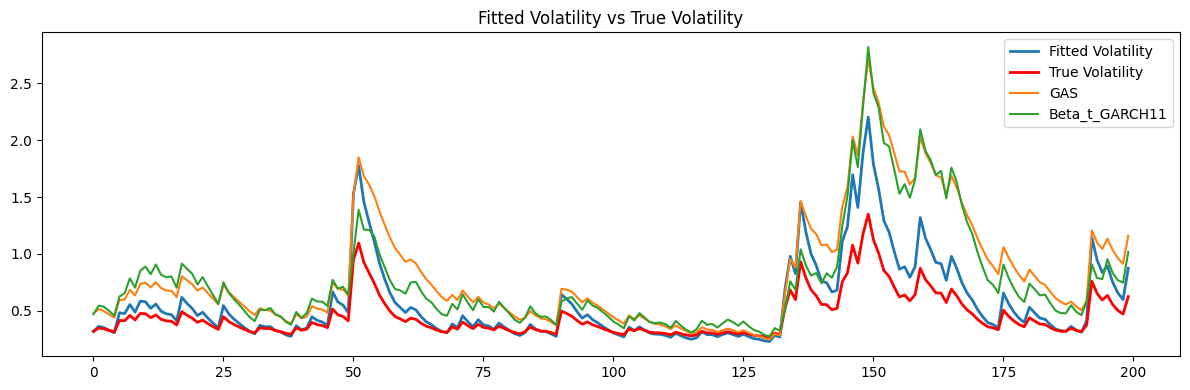

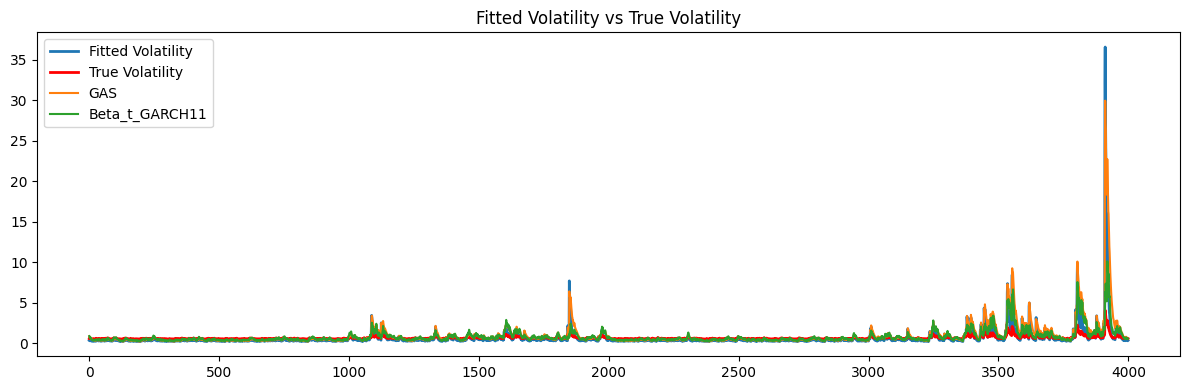

[0.3469733  0.31701344 0.29973487 ... 0.43628651 0.38671154 0.35541921]


In [44]:
#plot zoomed 
plt.figure(figsize=(12, 4))
plt.plot(QLE.fitted_volatility[3100:3300], label="Fitted Volatility", linewidth=2)
plt.plot(vol[3100:3300], color='red', label="True Volatility", linewidth=2)
plt.plot(gas_model.fitted_f[3100:3300], label = 'GAS')
plt.plot(beta_t_model.fitted_f[3100:3300], label = 'Beta_t_GARCH11')
plt.legend()
plt.title("Fitted Volatility vs True Volatility")
plt.tight_layout()
plt.show()

#plot the results
plt.figure(figsize=(12, 4))
plt.plot(QLE.fitted_volatility, label="Fitted Volatility", linewidth=2)
plt.plot(np.sqrt(vol), color='red', label="True Volatility", linewidth=2)
plt.plot(gas_model.fitted_f, label = 'GAS')
plt.plot(beta_t_model.fitted_f, label = 'Beta_t_GARCH11')
plt.legend()
plt.title("Fitted Volatility vs True Volatility")
plt.tight_layout()
plt.show()


#calc RMSE
print(QLE.fitted_volatility)

In [ ]:
#good seets so far: 42, 

SECOND TRY

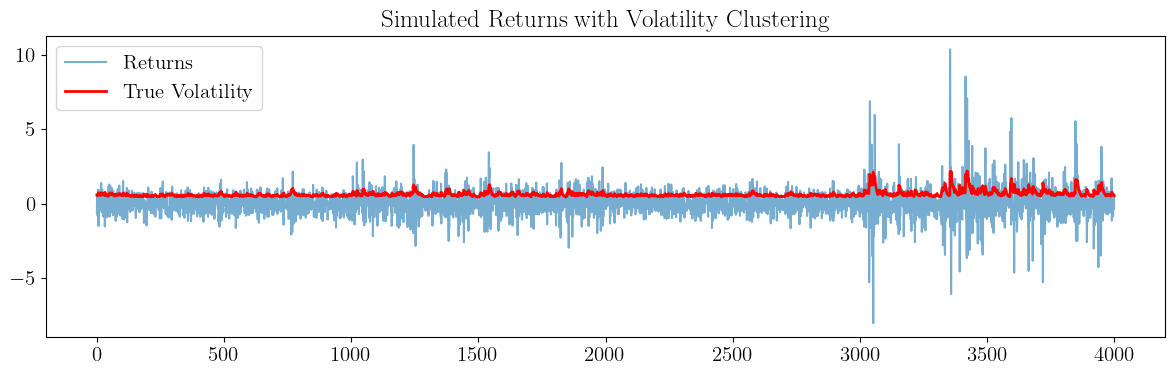

Optimization result: Desired error not necessarily achieved due to precision loss.
Parameters: {'omega': np.float64(0.11050048157549362), 'gamma': np.float64(0.22592851921447446), 'beta': np.float64(0.7683388113993743), 'alpha_loss': np.float64(1.5037735385003708), 'c': np.float64(0.8860978333397215)}


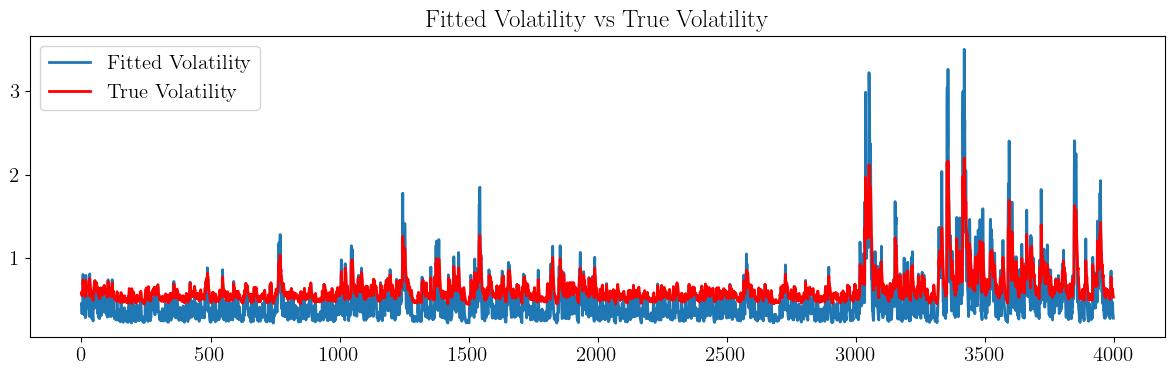

In [67]:
import os
from matplotlib import rc
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':'15'})
rc('text', usetex=True)

def simulate_qle_volatility_clusters(
    model_class,
    cluster_params: list,
    cluster_lengths: list,
    dist: str = 'normal',
    df: int = 5,
    seed: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulate return series with QLE dynamics and regime-based parameter changes.

    Args:
        model_class: A QLE volatility model class (e.g. RobustQLEVolatilityModel)
        cluster_params: List of dicts, each containing model parameters for one regime
        cluster_lengths: List of lengths of each cluster (must sum to total T)
        dist: 'normal' or 't'
        df: degrees of freedom if t-distributed
        seed: random seed
    Returns:
        y: full return series
        vol: true conditional variances
        regimes: regime indicator (same length as y)
    """
    true_params_regime = {
        'omega': 0.05,
        'gamma': 0.08,
        'beta': 0.85,
        'alpha_loss': 1.8,
        'c': 0.8
    }
    
    np.random.seed(seed)
    QLE = RobustQLEVolatilityModel(alpha_loss=true_params_regime['alpha_loss'], c=true_params_regime['c'])
    QLE.params = true_params_regime
   
    
    #create data that has normal and t-distributed returns accoring to Robust class
    y = np.ones(4000)
    y[0:1000], vol1 = QLE.simulate(1000, dist='normal')
    y[1000:2000], vol2 = QLE.simulate(1000, dist='t', df=5)
    y[2000:3000], vol3 = QLE.simulate(1000, dist='normal')
    y[3000:4000], vol4 = QLE.simulate(1000, dist='t', df=3)
    vol = np.concatenate([vol1, vol2, vol3, vol4])
    regimes = np.ones(4000)
    return y, vol, regimes

y, vol, regimes = simulate_qle_volatility_clusters(RobustQLEVolatilityModel, [0.05, 0.08, 0.02], [3000, 3000, 4000], dist='normal', df=5, seed=123)
#plot the data
plt.figure(figsize=(12, 4))
plt.plot(y, label="Returns", alpha=0.6)
plt.plot(np.sqrt(vol), color='red', label="True Volatility", linewidth=2)
plt.legend()
plt.title("Simulated Returns with Volatility Clustering")
plt.tight_layout()
plt.show()
#fit model to data

QLE = RobustQLEVolatilityModel()
QLE.fit(y, method ='BFGS')

#plot the results
plt.figure(figsize=(12, 4))
plt.plot(QLE.fitted_volatility, label="Fitted Volatility", linewidth=2)
plt.plot(np.sqrt(vol), color='red', label="True Volatility", linewidth=2)
plt.legend()
plt.title("Fitted Volatility vs True Volatility")
plt.tight_layout()
plt.show()






In [68]:
gas_model = GAS_Model(y)
gas_model.fit()

# Create and fit Beta-t-GARCH model for comparison
beta_t_model = Beta_t_GARCH11(y)
beta_t_model.fit()


Optimization terminated successfully.
         Current function value: 4502.833362
         Iterations: 99
         Function evaluations: 171


  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 4323.081291416111
        x: [ 3.477e-02  1.625e-01  7.824e-01  5.652e+00]
      nit: 20
      jac: [-8.267e-02 -6.821e-03 -3.884e-02 -8.185e-04]
     nfev: 130
     njev: 26
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

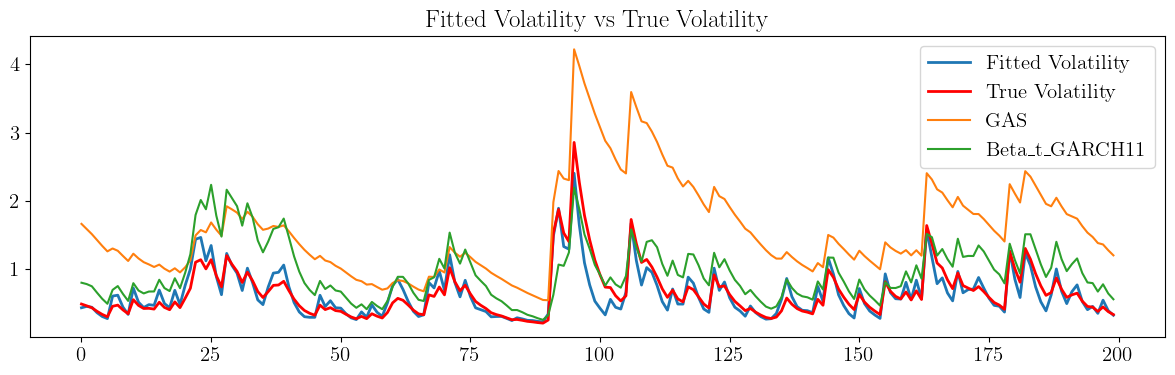

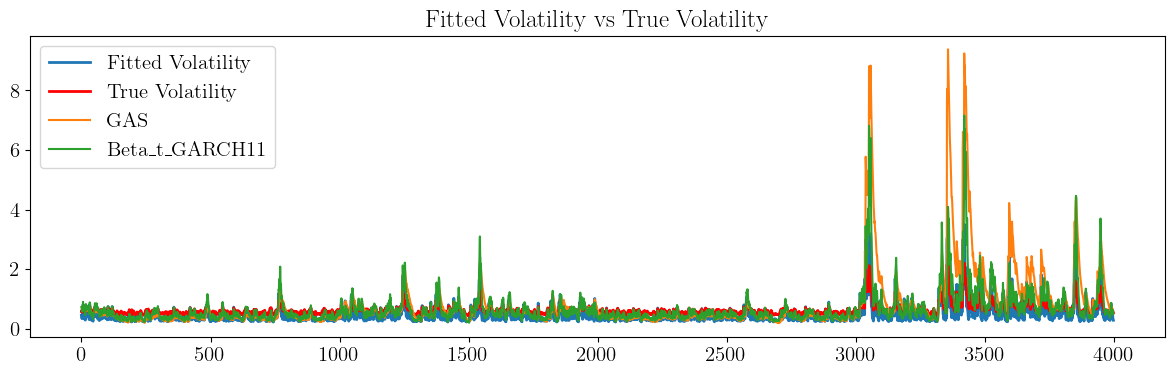

[0.45289249 0.42595391 0.33237415 ... 0.34714695 0.31611251 0.27952619]


In [69]:
#plot zoomed 
plt.figure(figsize=(12, 4))
plt.plot(QLE.fitted_volatility[3500:3700], label="Fitted Volatility", linewidth=2)
plt.plot(vol[3500:3700], color='red', label="True Volatility", linewidth=2)
plt.plot(gas_model.fitted_f[3500:3700], label = 'GAS')
plt.plot(beta_t_model.fitted_f[3500:3700], label = 'Beta_t_GARCH11')
plt.legend()
plt.title("Fitted Volatility vs True Volatility")
plt.tight_layout()
plt.show()

#plot the results
plt.figure(figsize=(12, 4))
plt.plot(QLE.fitted_volatility, label="Fitted Volatility", linewidth=2)
plt.plot(np.sqrt(vol), color='red', label="True Volatility", linewidth=2)
plt.plot(gas_model.fitted_f, label = 'GAS')
plt.plot(beta_t_model.fitted_f, label = 'Beta_t_GARCH11')
plt.legend()
plt.title("Fitted Volatility vs True Volatility")
plt.tight_layout()
plt.show()


#calc RMSE
print(QLE.fitted_volatility)

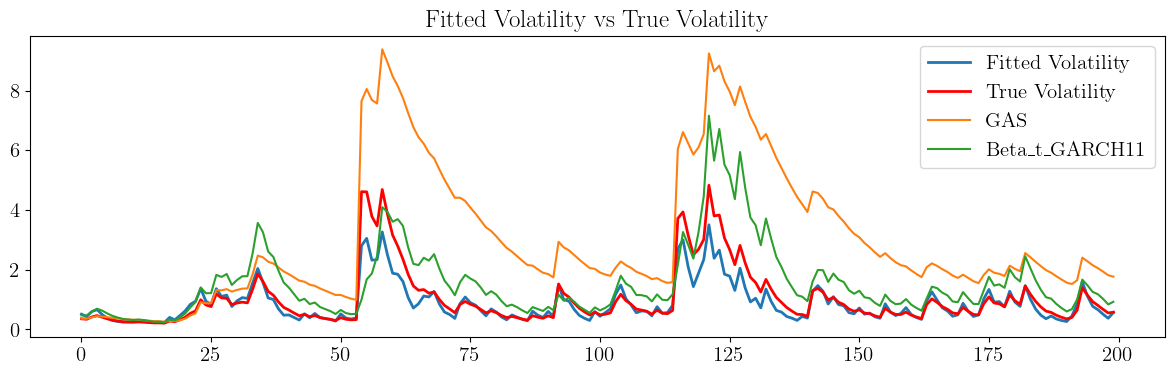

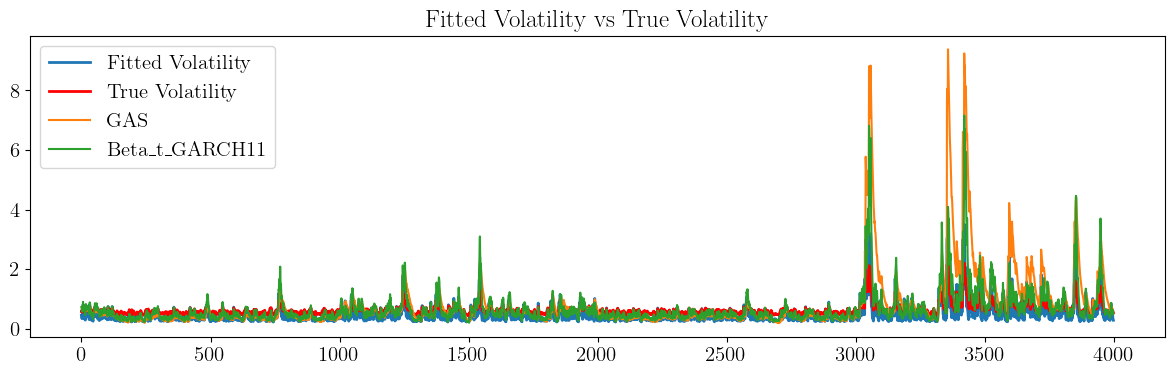

[0.45289249 0.42595391 0.33237415 ... 0.34714695 0.31611251 0.27952619]


In [70]:
#plot zoomed 
plt.figure(figsize=(12, 4))
plt.plot(QLE.fitted_volatility[3300:3500], label="Fitted Volatility", linewidth=2)
plt.plot(vol[3300:3500], color='red', label="True Volatility", linewidth=2)
plt.plot(gas_model.fitted_f[3300:3500], label = 'GAS')
plt.plot(beta_t_model.fitted_f[3300:3500], label = 'Beta_t_GARCH11')
plt.legend()
plt.title("Fitted Volatility vs True Volatility")
plt.tight_layout()
plt.show()

#plot the results
plt.figure(figsize=(12, 4))
plt.plot(QLE.fitted_volatility, label="Fitted Volatility", linewidth=2)
plt.plot(np.sqrt(vol), color='red', label="True Volatility", linewidth=2)
plt.plot(gas_model.fitted_f, label = 'GAS')
plt.plot(beta_t_model.fitted_f, label = 'Beta_t_GARCH11')
plt.legend()
plt.title("Fitted Volatility vs True Volatility")
plt.tight_layout()
plt.show()


#calc RMSE
print(QLE.fitted_volatility)

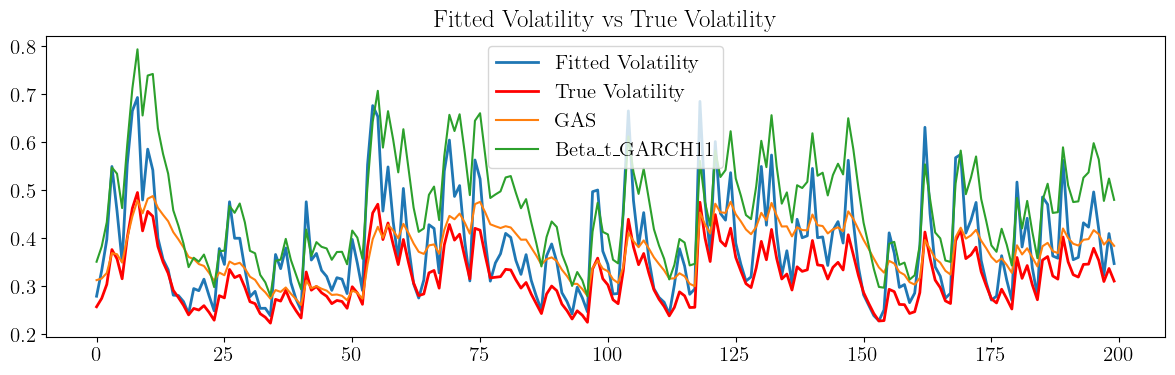

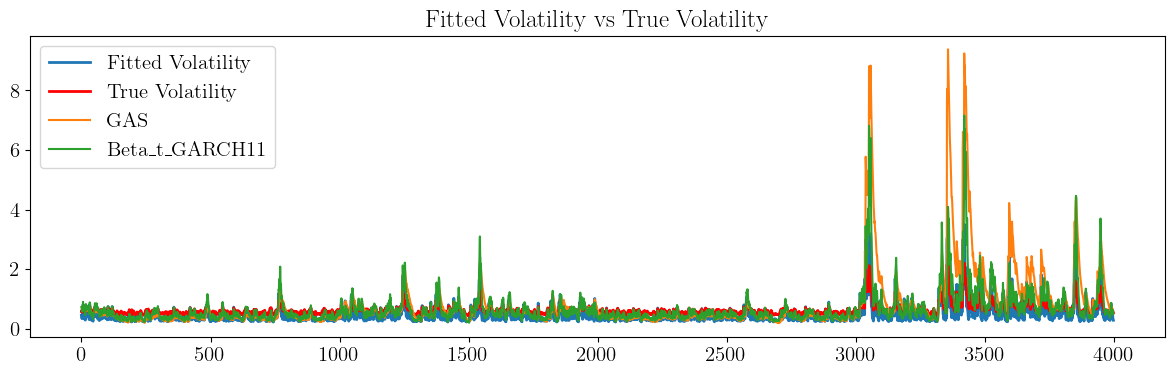

[0.45289249 0.42595391 0.33237415 ... 0.34714695 0.31611251 0.27952619]


In [71]:
#plot zoomed 
plt.figure(figsize=(12, 4))
plt.plot(QLE.fitted_volatility[2300:2500], label="Fitted Volatility", linewidth=2)
plt.plot(vol[2300:2500], color='red', label="True Volatility", linewidth=2)
plt.plot(gas_model.fitted_f[2300:2500], label = 'GAS')
plt.plot(beta_t_model.fitted_f[2300:2500], label = 'Beta_t_GARCH11')
plt.legend()
plt.title("Fitted Volatility vs True Volatility")
plt.tight_layout()
plt.show()

#plot the results
plt.figure(figsize=(12, 4))
plt.plot(QLE.fitted_volatility, label="Fitted Volatility", linewidth=2)
plt.plot(np.sqrt(vol), color='red', label="True Volatility", linewidth=2)
plt.plot(gas_model.fitted_f, label = 'GAS')
plt.plot(beta_t_model.fitted_f, label = 'Beta_t_GARCH11')
plt.legend()
plt.title("Fitted Volatility vs True Volatility")
plt.tight_layout()
plt.show()


#calc RMSE
print(QLE.fitted_volatility)

THIRD TRY MORE CLUSTERING, USED SO FAR IN THESIS

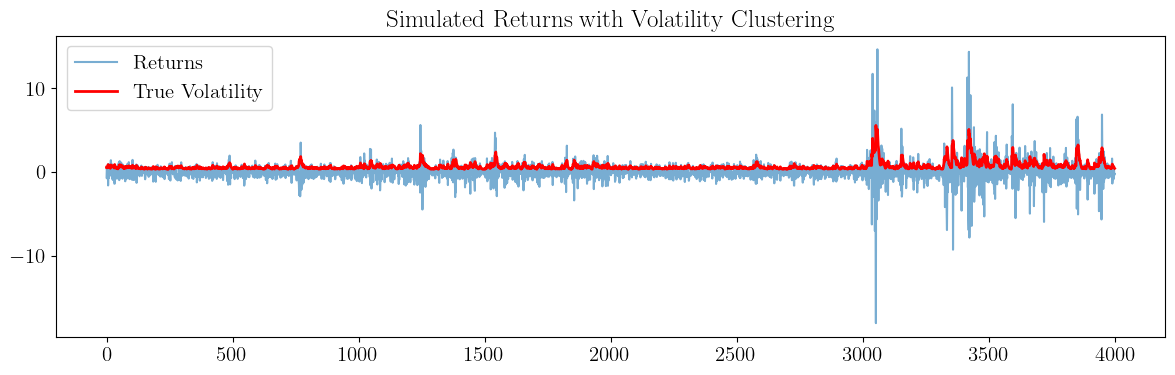

Optimization result: Desired error not necessarily achieved due to precision loss.
Parameters: {'omega': np.float64(0.005960350091642263), 'gamma': np.float64(0.2950480157478014), 'beta': np.float64(0.6969537239274279), 'alpha_loss': np.float64(1.7204890276467293), 'c': np.float64(0.7057196621114338)}


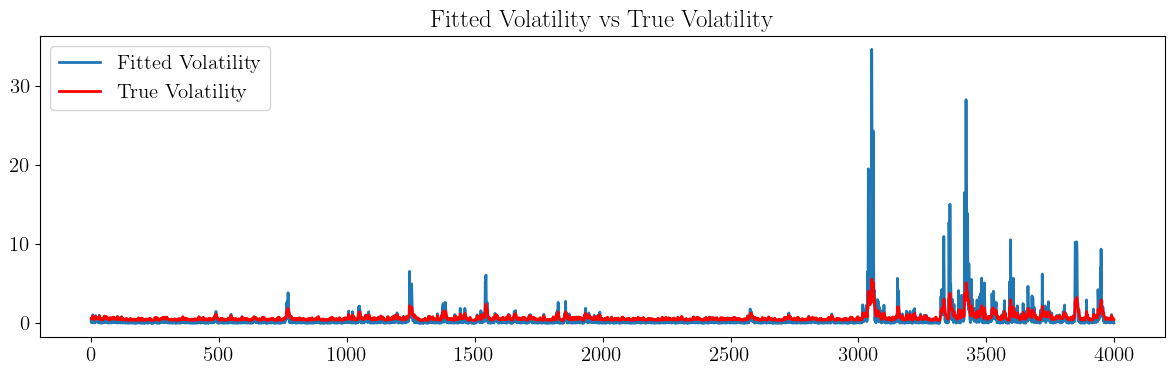

In [85]:
import os
from matplotlib import rc
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':'15'})
rc('text', usetex=True)

def simulate_qle_volatility_clusters(
    model_class,
    cluster_params: list,
    cluster_lengths: list,
    dist: str = 'normal',
    df: int = 5,
    seed: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulate return series with QLE dynamics and regime-based parameter changes.

    Args:
        model_class: A QLE volatility model class (e.g. RobustQLEVolatilityModel)
        cluster_params: List of dicts, each containing model parameters for one regime
        cluster_lengths: List of lengths of each cluster (must sum to total T)
        dist: 'normal' or 't'
        df: degrees of freedom if t-distributed
        seed: random seed
    Returns:
        y: full return series
        vol: true conditional variances
        regimes: regime indicator (same length as y)
    """
    true_params_regime = {
        'omega': 0.05,
        'gamma': 0.18,
        'beta': 0.85,
        'alpha_loss': 1.8,
        'c': 0.8
    }
    
    np.random.seed(seed)
    QLE = RobustQLEVolatilityModel(alpha_loss=true_params_regime['alpha_loss'], c=true_params_regime['c'])
    QLE.params = true_params_regime
   
    
    #create data that has normal and t-distributed returns accoring to Robust class
    y = np.ones(4000)
    y[0:1000], vol1 = QLE.simulate(1000, dist='normal')
    y[1000:2000], vol2 = QLE.simulate(1000, dist='t', df=5)
    y[2000:3000], vol3 = QLE.simulate(1000, dist='normal')
    y[3000:4000], vol4 = QLE.simulate(1000, dist='t', df=3)
    vol = np.concatenate([vol1, vol2, vol3, vol4])
    regimes = np.ones(4000)
    return y, vol, regimes

y, vol, regimes = simulate_qle_volatility_clusters(RobustQLEVolatilityModel, [0.05, 0.08, 0.02], [3000, 3000, 4000], dist='normal', df=5, seed=123)
#plot the data
plt.figure(figsize=(12, 4))
plt.plot(y, label="Returns", alpha=0.6)
plt.plot(np.sqrt(vol), color='red', label="True Volatility", linewidth=2)
plt.legend()
plt.title("Simulated Returns with Volatility Clustering")
plt.tight_layout()
plt.show()
#fit model to data

QLE = RobustQLEVolatilityModel()
param_est= QLE.fit(y, method ='BFGS')

#plot the results
plt.figure(figsize=(12, 4))
plt.plot(QLE.fitted_volatility, label="Fitted Volatility", linewidth=2)
plt.plot(np.sqrt(vol), color='red', label="True Volatility", linewidth=2)
plt.legend()
plt.title("Fitted Volatility vs True Volatility")
plt.tight_layout()
plt.show()






In [80]:
gas_model = GAS_Model(y)
gas_model.fit()

# Create and fit Beta-t-GARCH model for comparison
beta_t_model = Beta_t_GARCH11(y)
beta_t_model.fit()


Optimization terminated successfully.
         Current function value: 4559.262152
         Iterations: 73
         Function evaluations: 128


  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 4343.429794998645
        x: [ 4.564e-02  3.445e-01  6.092e-01  5.831e+00]
      nit: 13
      jac: [-1.537e-02 -1.382e-02 -2.083e-02  5.457e-04]
     nfev: 70
     njev: 14
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [90]:
model_l2 = RobustQLEVolatilityModel(alpha_loss=2)

model_alpha1_5 = RobustQLEVolatilityModel(alpha_loss=1.5)

# Cauchy loss model (should be robust)
model_cauchy = RobustQLEVolatilityModel(alpha_loss=0)

# Alpha=1 model (should be robust)
model_alpha1 = RobustQLEVolatilityModel(alpha_loss=1)

print("\nFitting standard QLE model (alpha=2):")
params_l2 = model_l2.fit(y, method='BFGS')

params_alpha1_5 = model_alpha1_5.fit(y, method='BFGS')

print("\nFitting robust model with Cauchy loss (alpha=0):")
params_cauchy = model_cauchy.fit(y, method='BFGS')

print("\nFitting robust model with alpha=1:")
params_alpha1 = model_alpha1.fit(y, method='BFGS')






Fitting standard QLE model (alpha=2):
Optimization result: Desired error not necessarily achieved due to precision loss.
Parameters: {'omega': np.float64(0.05198033459348392), 'gamma': np.float64(0.21543744797029118), 'beta': np.float64(0.7548480761235647), 'c': np.float64(0.9801289148145397)}
Optimization result: Desired error not necessarily achieved due to precision loss.
Parameters: {'omega': np.float64(0.09390445663911635), 'gamma': np.float64(0.1749618803856772), 'beta': np.float64(0.8106772951126804), 'c': np.float64(0.8920070094635123)}

Fitting robust model with Cauchy loss (alpha=0):
Optimization result: Desired error not necessarily achieved due to precision loss.
Parameters: {'omega': np.float64(0.3351884852565357), 'gamma': np.float64(0.21134873318423492), 'beta': np.float64(0.7613743517334415), 'c': np.float64(1.3346674743936378)}

Fitting robust model with alpha=1:
Optimization result: Desired error not necessarily achieved due to precision loss.
Parameters: {'omega': n

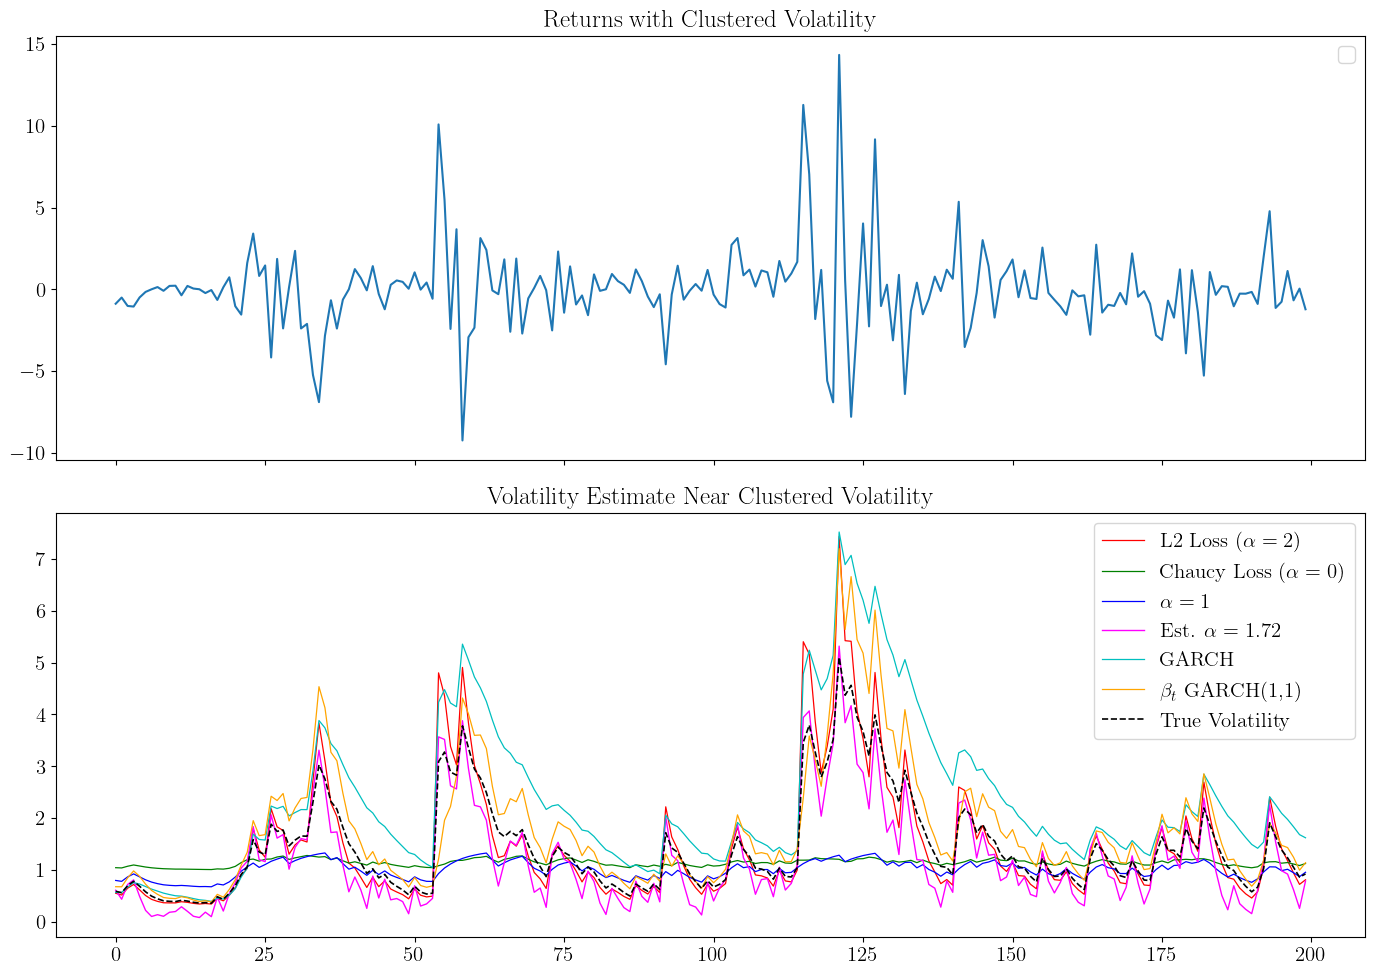

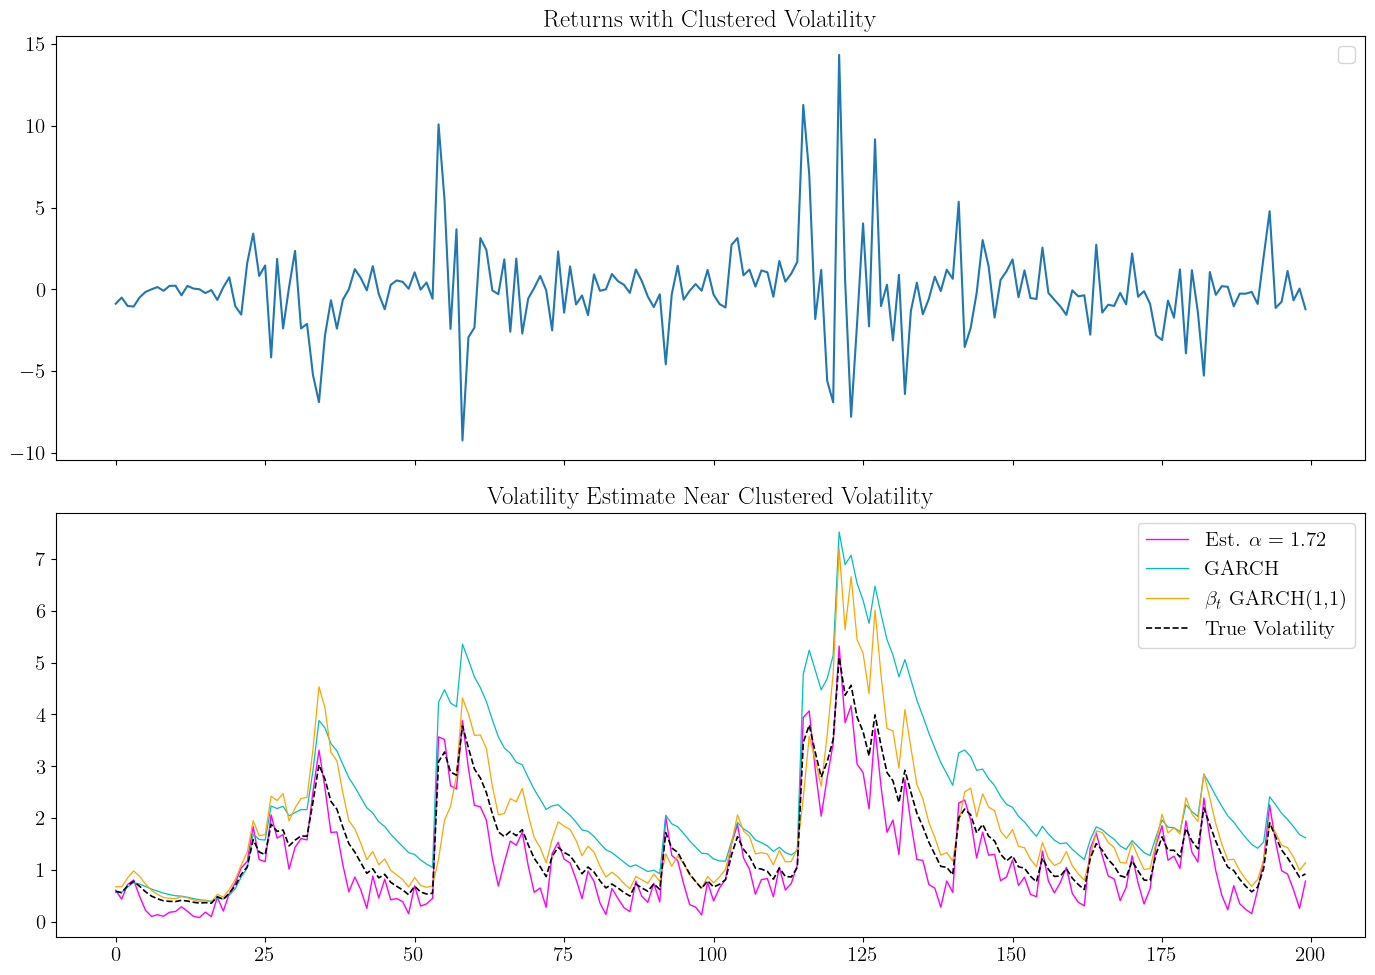

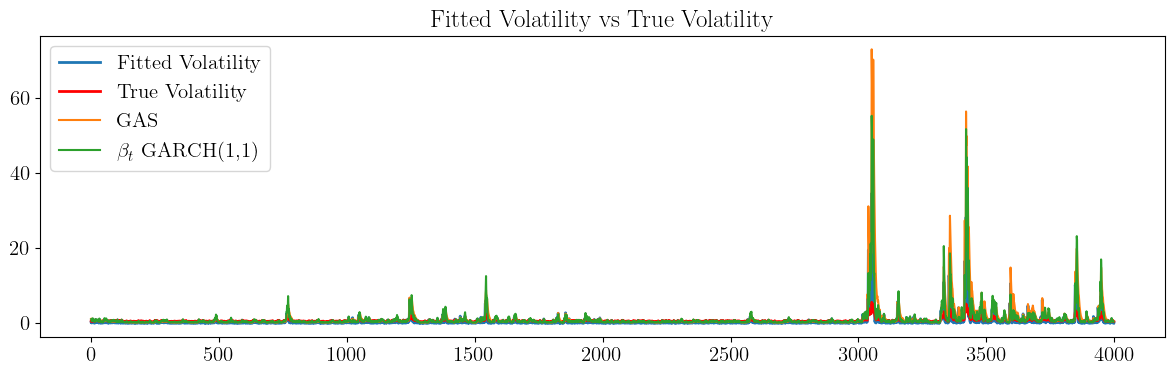

In [107]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axes[0].plot(y[3300:3500])
axes[0].legend()
axes[0].set_title("Returns with Clustered Volatility")
plt.tight_layout()

#plot zoomed 

axes[1].plot(np.sqrt(model_l2.fitted_volatility[3300:3500]), 'r-',label = rf'L2 Loss ($\alpha=2$)',linewidth=0.9)
axes[1].plot(np.sqrt(model_cauchy.fitted_volatility[3300:3500]), 'g-',label = rf'Chaucy Loss ($\alpha=0$)',linewidth=0.9)
axes[1].plot(np.sqrt(model_alpha1.fitted_volatility[3300:3500]), 'b-',label = rf'$\alpha=1$',linewidth=0.9)
axes[1].plot(np.sqrt(QLE.fitted_volatility[3300:3500]),  color='magenta',label=rf'Est. $\alpha={param_est["alpha_loss"]:.2f}$', linewidth=1)
axes[1].plot(np.sqrt(gas_model.fitted_f[3300:3500]), 'c-',label = 'GARCH',linewidth=0.9)
axes[1].plot(np.sqrt(beta_t_model.fitted_f[3300:3500]), 'orange',label = rf'$\beta_t$ GARCH(1,1)',linewidth=0.9)
axes[1].plot(np.sqrt(vol[3300:3500]), 'k--', label="True Volatility", linewidth=1.2)



axes[1].legend()
axes[1].set_title("Volatility Estimate Near Clustered Volatility")
plt.tight_layout()
plt.savefig('Structural_break_all_lines.pdf', format="pdf")
plt.show()

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axes[0].plot(y[3300:3500])
axes[0].legend()
axes[0].set_title("Returns with Clustered Volatility")
plt.tight_layout()

#plot zoomed 

axes[1].plot(np.sqrt(QLE.fitted_volatility[3300:3500]),  color='magenta',label=rf'Est. $\alpha={param_est["alpha_loss"]:.2f}$', linewidth=1)
axes[1].plot(np.sqrt(gas_model.fitted_f[3300:3500]), 'c-',label = 'GARCH',linewidth=0.9)
axes[1].plot(np.sqrt(beta_t_model.fitted_f[3300:3500]), 'orange',label = rf'$\beta_t$ GARCH(1,1)',linewidth=0.9)
axes[1].plot(np.sqrt(vol[3300:3500]), 'k--', label="True Volatility", linewidth=1.2)



axes[1].legend()
axes[1].set_title("Volatility Estimate Near Clustered Volatility")
plt.tight_layout()
plt.savefig('Structural_break_most_important.pdf', format="pdf")
plt.show()


#plot the results
plt.figure(figsize=(12, 4))
plt.plot(QLE.fitted_volatility, label="Fitted Volatility", linewidth=2)
plt.plot(np.sqrt(vol), color='red', label="True Volatility", linewidth=2)
plt.plot(gas_model.fitted_f, label = 'GAS')
plt.plot(beta_t_model.fitted_f, label = rf'$\beta_t$ GARCH(1,1)')
plt.legend()
plt.title("Fitted Volatility vs True Volatility")
plt.tight_layout()
plt.show()



FOURTH DIFFERENT INITIAL VALUES

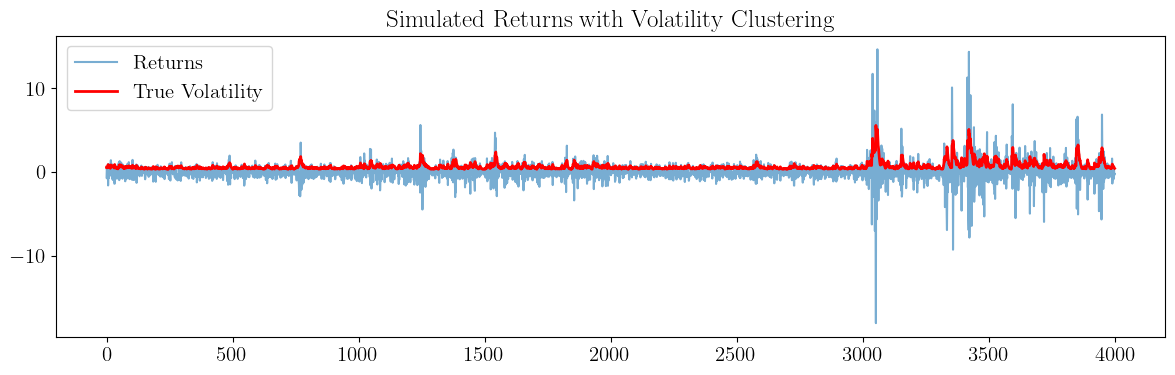

Optimization result: Desired error not necessarily achieved due to precision loss.
Parameters: {'omega': np.float64(0.036763924065192036), 'gamma': np.float64(0.1875711247283236), 'beta': np.float64(0.8103064303205522), 'alpha_loss': np.float64(1.8318329333214276), 'c': np.float64(0.784026088266297)}


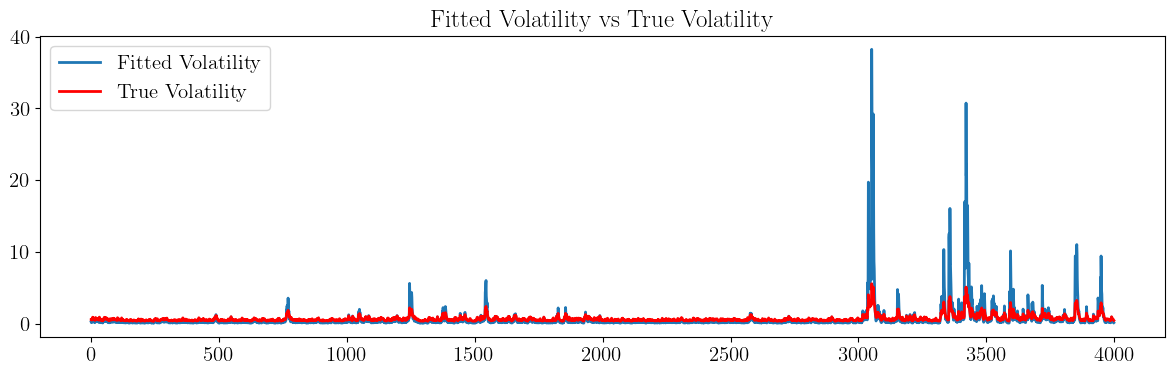

In [170]:
import os
from matplotlib import rc
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':'15'})
rc('text', usetex=True)

def simulate_qle_volatility_clusters(
    model_class,
    cluster_params: list,
    cluster_lengths: list,
    dist: str = 'normal',
    df: int = 5,
    seed: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulate return series with QLE dynamics and regime-based parameter changes.

    Args:
        model_class: A QLE volatility model class (e.g. RobustQLEVolatilityModel)
        cluster_params: List of dicts, each containing model parameters for one regime
        cluster_lengths: List of lengths of each cluster (must sum to total T)
        dist: 'normal' or 't'
        df: degrees of freedom if t-distributed
        seed: random seed
    Returns:
        y: full return series
        vol: true conditional variances
        regimes: regime indicator (same length as y)
    """
    true_params_regime = {
        'omega': 0.05,
        'gamma': 0.18,
        'beta': 0.85,
        'alpha_loss': 1.8,
        'c': 0.8
    }
    
    
    np.random.seed(seed)
    QLE = RobustQLEVolatilityModel(alpha_loss=true_params_regime['alpha_loss'], c=true_params_regime['c'])
    QLE.params = true_params_regime
   
    
    #create data that has normal and t-distributed returns accoring to Robust class
    y = np.ones(4000)
    y[0:1000], vol1 = QLE.simulate(1000, dist='normal')
    y[1000:2000], vol2 = QLE.simulate(1000, dist='t', df=5)
    y[2000:3000], vol3 = QLE.simulate(1000, dist='normal')
    y[3000:4000], vol4 = QLE.simulate(1000, dist='t', df=3)
    vol = np.concatenate([vol1, vol2, vol3, vol4])
    regimes = np.ones(4000)
    return y, vol, regimes


initial_param = {
        'omega': 0.05,
        'gamma': 0.15,
        'beta': 0.8,
        'alpha_loss': 1.8,
        'c': 0.8
    }


y, vol, regimes = simulate_qle_volatility_clusters(RobustQLEVolatilityModel, [0.05, 0.08, 0.02], [3000, 3000, 4000], dist='normal', df=5, seed=123)
#plot the data
plt.figure(figsize=(12, 4))
plt.plot(y, label="Returns", alpha=0.6)
plt.plot(np.sqrt(vol), color='red', label="True Volatility", linewidth=2)
plt.legend()
plt.title("Simulated Returns with Volatility Clustering")
plt.tight_layout()
plt.show()
#fit model to data

QLE = RobustQLEVolatilityModel()
param_est= QLE.fit(y, initial_params = initial_param, method ='BFGS')

#plot the results
plt.figure(figsize=(12, 4))
plt.plot(QLE.fitted_volatility, label="Fitted Volatility", linewidth=2)
plt.plot(np.sqrt(vol), color='red', label="True Volatility", linewidth=2)
plt.legend()
plt.title("Fitted Volatility vs True Volatility")
plt.tight_layout()
plt.show()






In [171]:
#other models

gas_model = GAS_Model(y)
gas_model.fit()

# Create and fit Beta-t-GARCH model for comparison
beta_t_model = Beta_t_GARCH11(y)
beta_t_model.fit()

model_l2 = RobustQLEVolatilityModel(alpha_loss=2)

model_alpha1_5 = RobustQLEVolatilityModel(alpha_loss=1.5)

# Cauchy loss model (should be robust)
model_cauchy = RobustQLEVolatilityModel(alpha_loss=0)

# Alpha=1 model (should be robust)
model_alpha1 = RobustQLEVolatilityModel(alpha_loss=1)

print("\nFitting standard QLE model (alpha=2):")
params_l2 = model_l2.fit(y, method='BFGS')

params_alpha1_5 = model_alpha1_5.fit(y, method='BFGS')

print("\nFitting robust model with Cauchy loss (alpha=0):")
params_cauchy = model_cauchy.fit(y, method='BFGS')

print("\nFitting robust model with alpha=1:")
params_alpha1 = model_alpha1.fit(y, method='BFGS')




Optimization terminated successfully.
         Current function value: 4559.262152
         Iterations: 73
         Function evaluations: 128

Fitting standard QLE model (alpha=2):
Optimization result: Desired error not necessarily achieved due to precision loss.
Parameters: {'omega': np.float64(0.05198033459348392), 'gamma': np.float64(0.21543744797029118), 'beta': np.float64(0.7548480761235647), 'c': np.float64(0.9801289148145397)}
Optimization result: Desired error not necessarily achieved due to precision loss.
Parameters: {'omega': np.float64(0.09390445663911635), 'gamma': np.float64(0.1749618803856772), 'beta': np.float64(0.8106772951126804), 'c': np.float64(0.8920070094635123)}

Fitting robust model with Cauchy loss (alpha=0):
Optimization result: Desired error not necessarily achieved due to precision loss.
Parameters: {'omega': np.float64(0.3351884852565357), 'gamma': np.float64(0.21134873318423492), 'beta': np.float64(0.7613743517334415), 'c': np.float64(1.3346674743936378)}


In [172]:
model_neginf = RobustQLEVolatilityModel(alpha_loss=float('-inf'))
param_est_neginf = model_neginf.fit(y, method='BFGS')

Optimization result: Desired error not necessarily achieved due to precision loss.
Parameters: {'omega': np.float64(0.4714848819227814), 'gamma': np.float64(0.01948262281480205), 'beta': np.float64(0.5493352515621406), 'c': np.float64(1.1072581062810207)}


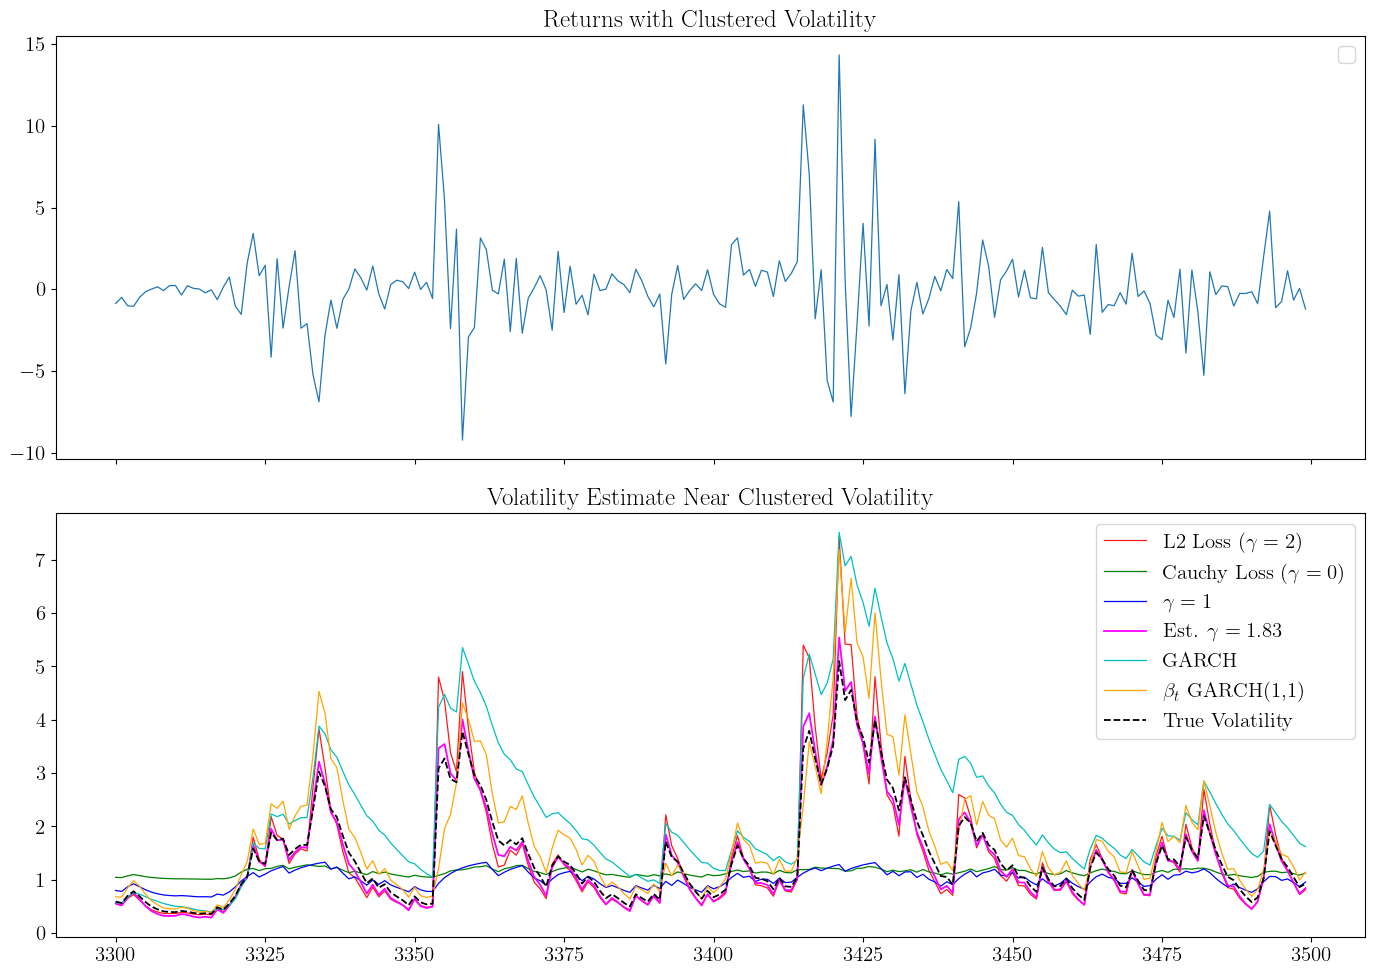

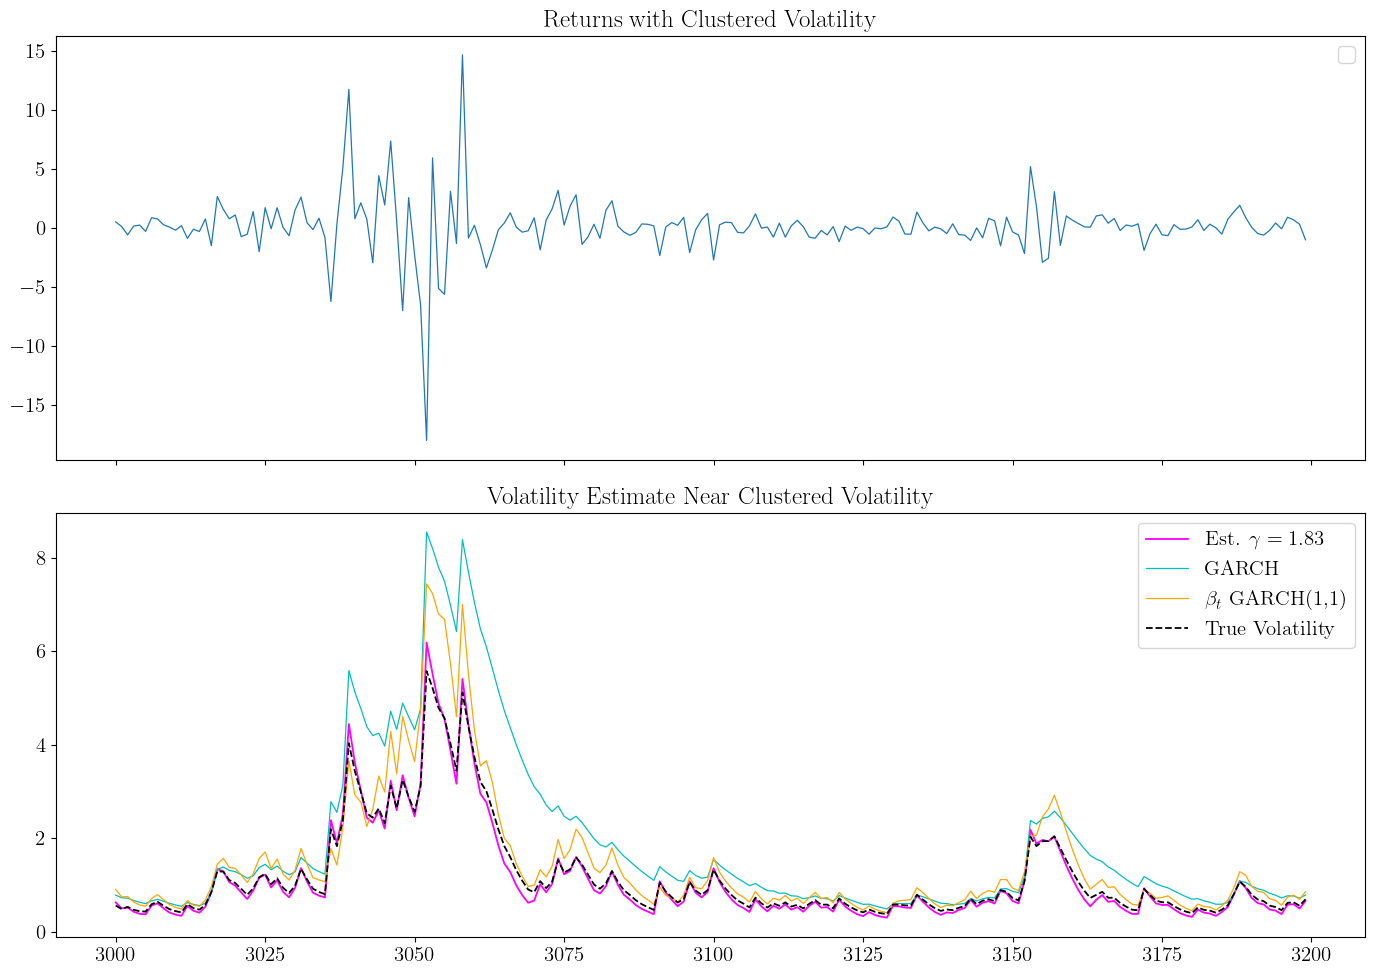

ValueError: x and y must have same first dimension, but have shapes (4000,) and (3999,)

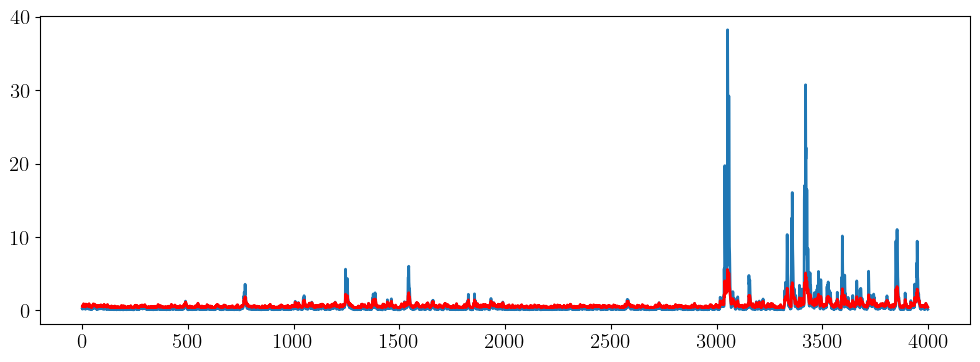

In [176]:
import numpy as np
import matplotlib.pyplot as plt

# === Plot 1 ===
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
start1, end1 = 3300, 3500
time1 = np.arange(start1, end1)

axes[0].set_title("Returns with Clustered Volatility")
axes[0].plot(time1, y[start1:end1], linewidth=0.9)
axes[0].legend()

#axes[1].plot(time1, np.sqrt(model_neginf.fitted_volatility[start1:end1]), label=rf'Welsch Loss ($\alpha=-\infty$)', linewidth=0.9)
axes[1].plot(time1, np.sqrt(model_l2.fitted_volatility[start1:end1]), 'r-', label=rf'L2 Loss ($\gamma=2$)', linewidth=0.9, alpha=0.9)
axes[1].plot(time1, np.sqrt(model_cauchy.fitted_volatility[start1:end1]), 'g-', label=rf'Cauchy Loss ($\gamma=0$)', linewidth=0.9)
axes[1].plot(time1, np.sqrt(model_alpha1.fitted_volatility[start1:end1]), 'b-', label=rf'$\gamma=1$', linewidth=0.9)
axes[1].plot(time1, np.sqrt(QLE.fitted_volatility[start1:end1]), color='magenta', label=rf'Est. $\gamma={param_est["alpha_loss"]:.2f}$', linewidth=1.3)
axes[1].plot(time1, np.sqrt(gas_model.fitted_f[start1:end1]), 'c-', label='GARCH', linewidth=0.9)
axes[1].plot(time1, np.sqrt(beta_t_model.fitted_f[start1:end1]), color='orange', label=rf'$\beta_t$ GARCH(1,1)', linewidth=0.9)
axes[1].plot(time1, np.sqrt(vol[start1:end1]), 'k--', label="True Volatility", linewidth=1.3)



axes[1].legend()
axes[1].set_title("Volatility Estimate Near Clustered Volatility")
plt.tight_layout()
plt.savefig('Structural_break_all_lines_multiple_clusters.pdf', format="pdf")
plt.show()

# === Plot 2 ===
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
start2, end2 = 3000, 3200
time2 = np.arange(start2, end2)

axes[0].plot(time2, y[start2:end2], linewidth=0.9)
axes[0].legend()
axes[0].set_title("Returns with Clustered Volatility")

#axes[1].plot(time2, np.sqrt(model_neginf.fitted_volatility[start2:end2]), label=rf'Welsch Loss ($\alpha=-\infty$)', linewidth=0.9)
# axes[1].plot(time2, np.sqrt(model_l2.fitted_volatility[start2:end2]), 'r-', label=rf'L2 Loss ($\gamma=2$)', linewidth=0.9)
# axes[1].plot(time2, np.sqrt(model_cauchy.fitted_volatility[start2:end2]), 'g-', label=rf'Cauchy Loss ($\gamma=0$)', linewidth=0.9)
# axes[1].plot(time2, np.sqrt(model_alpha1.fitted_volatility[start2:end2]), 'b-', label=rf'$\gamma=1$', linewidth=0.9)
axes[1].plot(time2, np.sqrt(QLE.fitted_volatility[start2:end2]), color='magenta', label=rf'Est. $\gamma={param_est["alpha_loss"]:.2f}$', linewidth=1.3)
axes[1].plot(time2, np.sqrt(gas_model.fitted_f[start2:end2]), 'c-', label='GARCH', linewidth=0.9)
axes[1].plot(time2, np.sqrt(beta_t_model.fitted_f[start2:end2]), color='orange', label=rf'$\beta_t$ GARCH(1,1)', linewidth=0.9)
axes[1].plot(time2, np.sqrt(vol[start2:end2]), 'k--', label="True Volatility", linewidth=1.3)

axes[1].legend()
axes[1].set_title("Volatility Estimate Near Clustered Volatility")
plt.tight_layout()
plt.savefig('Structural_break_most_important.pdf', format="pdf")
plt.show()



# === Plot 3: Full Volatility Comparison ===
time_full = np.arange(len(QLE.fitted_volatility))  # assuming full length is same for all

plt.figure(figsize=(12, 4))
plt.plot(time_full, QLE.fitted_volatility, label="Fitted Volatility", linewidth=2)
plt.plot(time_full, np.sqrt(vol), color='red', label="True Volatility", linewidth=2)
plt.plot(time_full, gas_model.fitted_f, label='GAS')
plt.plot(time_full, beta_t_model.fitted_f, label=rf'$\beta_t$ GARCH(1,1)')
plt.legend()
plt.title("Fitted Volatility vs True Volatility")
plt.tight_layout()
plt.show()


In [ ]:
#calc RMSE
rmse_est = np.sqrt(np.mean((QLE.fitted_volatility - vol)**2))
print(rmse_est)

rmse_1= np.sqrt(np.mean((model_alpha1.fitted_volatility- vol)**2))
print(rmse_1)


rmse_0= np.sqrt(np.mean((model_cauchy.fitted_volatility- vol)**2))
print(rmse_0)

rmse_beta= np.sqrt(np.mean((beta_t_model.fitted_f- vol[1:])**2))
print(rmse_beta)

rmse_2= np.sqrt(np.mean((model_l2.fitted_volatility- vol)**2))
print(rmse_2)

rmse_garch= np.sqrt(np.mean((gas_model.fitted_f- vol[1:])**2))
print(rmse_garch)



0.23522726627213192
1.5581256670794932
1.6990208351981428
1.7895158412670777
1.2929513090091764
3.1285918506203756
